<a href="https://colab.research.google.com/github/grabuffo/BrainStim_ANN_fMRI_HCP/blob/main/notebooks/TMS_fMRI_ANN_Simulate_Sessions_dataset_simulated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/grabuffo/BrainStim_ANN_fMRI_HCP/blob/main/notebooks/TMS_fMRI_ANN_Simulate_Sessions_dataset_simulated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simulate TMS-fMRI sessions with population ANN (dataset_simulated)

Creates a `dataset_simulated` dictionary mirroring the empirical `dataset` structure and saves it to Google Drive.


In [28]:

# =========================
# 0) Mount Google Drive
# =========================
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:

# =========================
# 1) Clone repo + imports
# =========================
import os, sys, pickle, json, math
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

REPO_DIR = "/content/BrainStim_ANN_fMRI_HCP"
if not os.path.exists(REPO_DIR):
    !git clone https://github.com/grabuffo/BrainStim_ANN_fMRI_HCP.git
else:
    print("Repo already exists ✅")

sys.path.append(REPO_DIR)

from src.NPI import build_model, device
print("Torch device:", device)


Repo already exists ✅
Torch device: cpu


In [30]:

# =========================
# 2) Paths (EDIT IF NEEDED)
# =========================
BASE = "/content/drive/MyDrive/Colab Notebooks/Brain_Stim_ANN/data"

DATASET_EMP_PKL = os.path.join(BASE, "TMS_fMRI", "dataset_tian50_schaefer400_allruns.pkl")

PREPROC_ROOT = os.path.join(BASE, "preprocessed_subjects_tms_fmri")
MODEL_DIR = os.path.join(PREPROC_ROOT, "trained_models_MLP_tms_fmri")

MODEL_PATH = None
for cand in [
    os.path.join(MODEL_DIR, "population_MLP_tms_fmri.pt"),
    os.path.join(MODEL_DIR, "population_MLP_tms_fmri.pth"),
]:
    if os.path.exists(cand):
        MODEL_PATH = cand
        break

OUT_DIR = os.path.join(PREPROC_ROOT, "ANN_vs_tms_fmri")
os.makedirs(OUT_DIR, exist_ok=True)
OUT_PKL = os.path.join(OUT_DIR, "dataset_simulated_populationANN.pkl")

print("Empirical dataset:", DATASET_EMP_PKL, "| exists:", os.path.exists(DATASET_EMP_PKL))
print("Model:", MODEL_PATH)
print("Will save to:", OUT_PKL)


Empirical dataset: /content/drive/MyDrive/Colab Notebooks/Brain_Stim_ANN/data/TMS_fMRI/dataset_tian50_schaefer400_allruns.pkl | exists: True
Model: /content/drive/MyDrive/Colab Notebooks/Brain_Stim_ANN/data/preprocessed_subjects_tms_fmri/trained_models_MLP_tms_fmri/population_MLP_tms_fmri.pt
Will save to: /content/drive/MyDrive/Colab Notebooks/Brain_Stim_ANN/data/preprocessed_subjects_tms_fmri/ANN_vs_tms_fmri/dataset_simulated_populationANN.pkl


In [31]:

# =========================
# 3) Load empirical dataset
# =========================
with open(DATASET_EMP_PKL, "rb") as f:
    dataset_emp = pickle.load(f)

print("Loaded subjects:", len(dataset_emp))


/tmp/ipython-input-1169829996.py:5: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  dataset_emp = pickle.load(f)


Loaded subjects: 46


In [98]:

# =========================
# 4) Config
# =========================
S = 3
N = 450

TR_MODEL = 2.0          # model step in seconds (trained on rest TR=2s)
BURN_IN = 10           # steps (not saved)
NOISE_SIGMA = 0.3      # z-scored units
STIM_AMP = 0.5          # z-scored units

MAP_MODE = "round"      # "round" | "floor" | "ceil" for mapping onset_s -> model steps

rng = np.random.default_rng(0)



# --- distributed stimulation kernel ---
RHO_MM = 10.0  # Gaussian spread (mm)

# Distance matrix (450x450) in mm
DIST_PATH = os.path.join(BASE, "TMS_fMRI", "atlases", "distance_matrix_450x450_Tian50_Schaefer400.npy")
D = np.load(DIST_PATH)  # shape (450,450)
assert D.shape == (N, N)

# Gaussian weights for every possible target (450 targets -> 450x450 profiles)
W = np.exp(-(D ** 2) / (2.0 * (RHO_MM ** 2))).astype(np.float32)

# Normalization choice:
# Option A (recommended): L2-normalize each target profile so "energy" is constant across targets
#W /= (np.linalg.norm(W, axis=1, keepdims=True) + 1e-8)

# Also ensure target gets max weight ~ 1 after normalization? (optional)
# If you want target weight to be exactly 1, uncomment:
W /= (W[np.arange(N), np.arange(N)][:, None] + 1e-8)

print("Loaded distance matrix:", D.min(), "to", D.max(), "mm")
print("W shape:", W.shape, "| example target profile stats:",
      "min", float(W[0].min()), "max", float(W[0].max()), "sum", float(W[0].sum()))



Loaded distance matrix: 0.0 to 170.50086775722426 mm
W shape: (450, 450) | example target profile stats: min 1.8725794046266553e-25 max 1.0 sum 4.597404479980469


In [99]:

# =========================
# 5) Helpers
# =========================
def get_onset_column(df: pd.DataFrame):
    if df is None or len(df) == 0:
        return None
    for c in ["onset", "Onset", "stim_onset", "onset_s", "onset_sec", "time", "t", "seconds"]:
        if c in df.columns:
            return c
    for c in df.columns:
        if pd.api.types.is_numeric_dtype(df[c]):
            return c
    return None

def map_onsets_to_steps(onsets_s, tr_model=TR_MODEL, mode=MAP_MODE):
    onsets_s = np.asarray(onsets_s, dtype=float)
    x = onsets_s / float(tr_model)
    if mode == "round":
        steps = np.rint(x).astype(int)
    elif mode == "floor":
        steps = np.floor(x).astype(int)
    elif mode == "ceil":
        steps = np.ceil(x).astype(int)
    else:
        raise ValueError("mode must be round|floor|ceil")
    steps = steps[steps >= 0]
    return np.unique(steps)

def safe_target_idx(target_vec):
    if target_vec is None:
        return None
    v = np.asarray(target_vec).astype(int).ravel()
    if v.size == 0 or v.sum() != 1:
        return None
    return int(np.argmax(v))

@torch.no_grad()
def predict_next(model, window_SxN: np.ndarray):
    """
    Predict next state with Gaussian noise (0.3 std)
    added to the flattened input window.
    """
    # Flatten window
    x_np = window_SxN.reshape(-1).astype(np.float32)

    # Add input noise EXACTLY like first version
    noise = NOISE_SIGMA * rng.normal(0.0, 1.0, size=x_np.shape).astype(np.float32)
    x_np = x_np + noise

    # Forward pass
    x = torch.tensor(x_np[None, :], dtype=torch.float32, device=device)
    y = model(x)

    return y.detach().cpu().numpy().squeeze(0)


def simulate_run(model, init_window_SxN, n_steps,
                 stim_steps=None, target_idx=None,
                 stim_amp=STIM_AMP,
                 burn_in=BURN_IN, W=None):

    init_window_SxN = np.asarray(init_window_SxN, dtype=np.float32)
    assert init_window_SxN.shape == (S, N)

    stim_steps = set(int(s) for s in (stim_steps or []))
    do_stim = (target_idx is not None) and (len(stim_steps) > 0)

    w = init_window_SxN.copy()

    # -----------------
    # Burn-in
    # -----------------
    for _ in range(burn_in):
        y = predict_next(model, w)
        w = np.vstack([w[1:], y[None, :]])

    # -----------------
    # Session
    # -----------------
    out = np.zeros((n_steps, N), dtype=np.float32)

    for t in range(n_steps):
        w_in = w.copy()
        if do_stim and (t in stim_steps):
          if W is None:
            w_in[-1, target_idx] += stim_amp
          else:
            w_in[-1, :] += stim_amp * W[target_idx, :]

        y = predict_next(model, w_in)

        out[t] = y
        w = np.vstack([w[1:], y[None, :]])

    meta_sim = {
        "tr_model_s": float(TR_MODEL),
        "burn_in_steps": int(burn_in),
        "noise_input_sigma": 0.3,  # matches original exactly
        "stim_amp": float(stim_amp),
        "stim_steps_modelTR": sorted(list(stim_steps)) if do_stim else [],
        "stim_mapping_mode": MAP_MODE,
    }

    return out, meta_sim


# @torch.no_grad()
# def predict_next(model, window_SxN: np.ndarray):
#     x = torch.tensor(window_SxN.reshape(1, -1), dtype=torch.float32, device=device)
#     y = model(x)
#     return y.detach().cpu().numpy().squeeze(0)

# def simulate_run(model, init_window_SxN, n_steps, stim_steps=None, target_idx=None,
#                  stim_amp=STIM_AMP, noise_sigma=NOISE_SIGMA, burn_in=BURN_IN, W=None):
#     init_window_SxN = np.asarray(init_window_SxN, dtype=np.float32)
#     assert init_window_SxN.shape == (S, N)

#     stim_steps = set(int(s) for s in (stim_steps or []))
#     do_stim = (target_idx is not None) and (len(stim_steps) > 0)

#     w = init_window_SxN.copy()

#     # burn-in
#     for _ in range(burn_in):
#         y = predict_next(model, w)
#         if noise_sigma > 0:
#             y = y + rng.normal(0, noise_sigma, size=y.shape).astype(np.float32)
#         w = np.vstack([w[1:], y[None, :]])

#     # session
#     out = np.zeros((n_steps, N), dtype=np.float32)
#     for t in range(n_steps):
#         w_in = w.copy()
#         if do_stim and (t in stim_steps):
#           if W is None:
#             w_in[-1, target_idx] += stim_amp
#           else:
#             w_in[-1, :] += stim_amp * W[target_idx, :]
#         y = predict_next(model, w_in)
#         if noise_sigma > 0:
#             y = y + rng.normal(0, noise_sigma, size=y.shape).astype(np.float32)
#         out[t] = y
#         w = np.vstack([w[1:], y[None, :]])

#     meta_sim = {
#         "tr_model_s": float(TR_MODEL),
#         "burn_in_steps": int(burn_in),
#         "noise_sigma": float(noise_sigma),
#         "stim_amp": float(stim_amp),
#         "stim_steps_modelTR": sorted(list(stim_steps)) if do_stim else [],
#         "stim_mapping_mode": MAP_MODE,
#     }
#     return out, meta_sim


In [100]:
# =========================
# 6) Load model (robust to PyTorch 2.6+)
# =========================
if MODEL_PATH is None:
    raise FileNotFoundError("Could not find population model checkpoint in MODEL_DIR.")

METHOD = "MLP"
model = build_model(METHOD, ROI_num=N, using_steps=S).to(device)

try:
    state = torch.load(MODEL_PATH, map_location=device, weights_only=True)
    if isinstance(state, dict) and "state_dict" in state:
        model.load_state_dict(state["state_dict"])
    elif isinstance(state, dict):
        model.load_state_dict(state)
    else:
        raise RuntimeError("weights_only=True returned non-dict; falling back.")
    print("Loaded weights with weights_only=True")
except Exception as e:
    print("weights_only=True failed; using weights_only=False")
    print("Reason:", repr(e))
    state = torch.load(MODEL_PATH, map_location=device, weights_only=False)
    if isinstance(state, dict) and "state_dict" in state:
        model.load_state_dict(state["state_dict"])
    elif isinstance(state, dict):
        model.load_state_dict(state)
    else:
        model = state.to(device)

model.eval()
print("Model ready.")


weights_only=True failed; using weights_only=False
Reason: UnpicklingError('Weights only load failed. This file can still be loaded, to do so you have two options, \x1bdo those steps only if you trust the source of the checkpoint\x1b. \n\t(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.\n\t(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.\n\tWeightsUnpickler error: Unsupported global: GLOBAL src.NPI.ANN_MLP was not an allowed global by default. Please use `torch.serialization.add_safe_globals([src.NPI.ANN_MLP])` or the `torch.serialization.safe_globals([src.NPI.ANN_MLP])` context manager to allowlist this global if you trust this class/function.\n\nCheck the documentatio

In [101]:
# =========================
# 7) Build dataset_simulated
# =========================
dataset_sim = {}
n_sim_runs = 0

for sub_id, sub_data in dataset_emp.items():
    dataset_sim[sub_id] = {"task-rest": {}, "task-stim": {}}

    # ---- REST ----
    if "task-rest" in sub_data:
        for run_idx, run in sub_data["task-rest"].items():
            ts_emp = run.get("time series", None)
            md_emp = run.get("metadata", {}) or {}
            if ts_emp is None or not isinstance(ts_emp, np.ndarray) or ts_emp.shape[1] != N:
                continue

            tr_emp = float(md_emp.get("tr_s", 2.0))
            dur_s = ts_emp.shape[0] * tr_emp
            n_steps = int(math.ceil(dur_s / TR_MODEL))

            init_window = ts_emp[:S].copy()
            sim_ts, meta_sim = simulate_run(model, init_window, n_steps)

            md_out = dict(md_emp)
            md_out.update({
                "simulated": True,
                "source_empirical_task": "task-rest",
                "source_run_idx": int(run_idx),
                "duration_emp_s": float(dur_s),
                "n_steps_model": int(n_steps),
                **meta_sim
            })

            md_out["stim_kernel"] = "gaussian"
            md_out["rho_mm"] = float(RHO_MM)
            md_out["dist_matrix_path"] = DIST_PATH
            md_out["stim_profile_normalization"] = "L2"


            dataset_sim[sub_id]["task-rest"][int(run_idx)] = {
                "time series": sim_ts,
                "metadata": md_out
            }
            n_sim_runs += 1

    # ---- STIM ----
    if "task-stim" in sub_data:
        for run_idx, run in sub_data["task-stim"].items():
            ts_emp = run.get("time series", None)
            md_emp = run.get("metadata", {}) or {}
            target_vec = run.get("target", None)
            events_df = run.get("stim time", None)

            if ts_emp is None or not isinstance(ts_emp, np.ndarray) or ts_emp.shape[1] != N:
                continue

            target_idx = safe_target_idx(target_vec)
            if target_idx is None:
                continue

            onset_col = get_onset_column(events_df) if isinstance(events_df, pd.DataFrame) else None
            if onset_col is None:
                continue

            onsets_s = events_df[onset_col].astype(float).values
            stim_steps = list(map_onsets_to_steps(onsets_s, tr_model=TR_MODEL, mode=MAP_MODE))

            tr_emp = float(md_emp.get("tr_s", 2.4))
            dur_s = ts_emp.shape[0] * tr_emp
            n_steps = int(math.ceil(dur_s / TR_MODEL))

            init_window = ts_emp[:S].copy()
            sim_ts, meta_sim = simulate_run(model, init_window, n_steps,
                                            stim_steps=stim_steps, target_idx=target_idx, W=W)

            md_out = dict(md_emp)
            md_out.update({
                "simulated": True,
                "source_empirical_task": "task-stim",
                "source_run_idx": int(run_idx),
                "duration_emp_s": float(dur_s),
                "n_steps_model": int(n_steps),
                "target_idx": int(target_idx),
                **meta_sim
            })

            dataset_sim[sub_id]["task-stim"][int(run_idx)] = {
                "time series": sim_ts,
                "metadata": md_out,
                "target": target_vec,
                "stim time": events_df,
            }
            n_sim_runs += 1

print("Simulated runs:", n_sim_runs)


Simulated runs: 481


In [102]:
# =========================
# 8) Save to Drive
# =========================
with open(OUT_PKL, "wb") as f:
    pickle.dump(dataset_sim, f, protocol=pickle.HIGHEST_PROTOCOL)

print("Saved dataset_simulated to:", OUT_PKL)

# Quick peek
some_sub = next(iter(dataset_sim.keys()), None)
if some_sub:
    print("Example subject:", some_sub)
    print("task-rest runs:", list(dataset_sim[some_sub]["task-rest"].keys())[:5])
    print("task-stim runs:", list(dataset_sim[some_sub]["task-stim"].keys())[:5])
    if dataset_sim[some_sub]["task-stim"]:
        r0 = next(iter(dataset_sim[some_sub]["task-stim"].keys()))
        md0 = dataset_sim[some_sub]["task-stim"][r0]["metadata"]
        print("Example stim target_idx:", md0.get("target_idx"))
        print("Example stim mapped steps (first 10):", md0.get("stim_steps_modelTR", [])[:10])


Saved dataset_simulated to: /content/drive/MyDrive/Colab Notebooks/Brain_Stim_ANN/data/preprocessed_subjects_tms_fmri/ANN_vs_tms_fmri/dataset_simulated_populationANN.pkl
Example subject: sub-NTHC1001
task-rest runs: [0]
task-stim runs: [0]
Example stim target_idx: 401
Example stim mapped steps (first 10): [6, 7, 14, 18, 22, 25, 26, 28, 30, 32]


In [103]:
dataset_emp['sub-NTHC1001']['task-rest'][0]['time series'].shape

(240, 450)

In [116]:
dataset_emp.keys()

dict_keys(['sub-NTHC1001', 'sub-NTHC1003', 'sub-NTHC1009', 'sub-NTHC1015', 'sub-NTHC1016', 'sub-NTHC1019', 'sub-NTHC1021', 'sub-NTHC1022', 'sub-NTHC1023', 'sub-NTHC1024', 'sub-NTHC1026', 'sub-NTHC1027', 'sub-NTHC1028', 'sub-NTHC1029', 'sub-NTHC1032', 'sub-NTHC1035', 'sub-NTHC1036', 'sub-NTHC1037', 'sub-NTHC1038', 'sub-NTHC1039', 'sub-NTHC1040', 'sub-NTHC1043', 'sub-NTHC1047', 'sub-NTHC1049', 'sub-NTHC1050', 'sub-NTHC1052', 'sub-NTHC1053', 'sub-NTHC1055', 'sub-NTHC1056', 'sub-NTHC1057', 'sub-NTHC1061', 'sub-NTHC1062', 'sub-NTHC1064', 'sub-NTHC1065', 'sub-NTHC1066', 'sub-NTHC1068', 'sub-NTHC1073', 'sub-NTHC1075', 'sub-NTHC1097', 'sub-NTHC1098', 'sub-NTHC1099', 'sub-NTHC1101', 'sub-NTHC1102', 'sub-NTHC1105', 'sub-NTHC1107', 'sub-NTHC1108'])

In [123]:
# Empirical vs simulated time series, FC, and dFC
from scipy import stats

def go_edge(tseries):
    nregions=tseries.shape[1]
    Blen=tseries.shape[0]
    nedges=int(nregions**2/2-nregions/2)
    iTriup= np.triu_indices(nregions,k=1)
    gz=stats.zscore(tseries)
    Eseries = gz[:,iTriup[0]]*gz[:,iTriup[1]]
    return Eseries

def dFC(tseries):
    return np.corrcoef(go_edge(tseries))

#test_dur=210 #int(len(Z)-len(Z)/100*80) #3000

sid='sub-NTHC1015'

emp_rest=dataset_emp[sid]['task-rest'][0]['time series']#stim
emp_stim=dataset_emp[sid]['task-stim'][0]['time series']#stim
sim_rest=dataset_sim[sid]['task-rest'][0]['time series']#stim
sim_stim=dataset_sim[sid]['task-stim'][0]['time series']#stim

FC_emp_rest=np.corrcoef(emp_rest.T)
FC_emp_stim=np.corrcoef(emp_stim.T)
FC_sim_rest=np.corrcoef(sim_rest.T)
FC_sim_stim=np.corrcoef(sim_stim.T)

dFC_emp_rest=dFC(emp_rest)
dFC_emp_stim=dFC(emp_stim)
dFC_sim_rest=dFC(sim_rest)
dFC_sim_stim=dFC(sim_stim)

In [124]:
FC_emp_rest.shape

(450, 450)

In [125]:
dFC_emp_stim.shape

(167, 167)

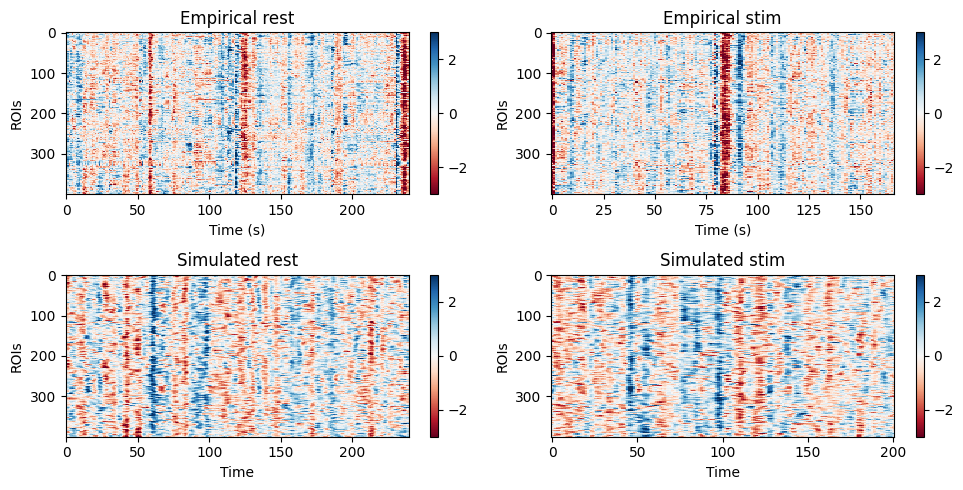

In [126]:
n=400


plt.figure(figsize=(10,5))
plt.subplot(2,2,1)
plt.title('Empirical rest')
plt.imshow(stats.zscore(emp_rest[:,-n:],axis=0).T,aspect='auto',vmin=-3,vmax=3,cmap='RdBu',interpolation='nearest')
plt.colorbar()
plt.xlabel('Time (s)')
plt.ylabel('ROIs')

plt.subplot(2,2,2)
plt.title('Empirical stim')
plt.imshow(stats.zscore(emp_stim[:,-n:],axis=0).T,aspect='auto',vmin=-3,vmax=3,cmap='RdBu',interpolation='nearest')
plt.colorbar()
plt.xlabel('Time (s)')
plt.ylabel('ROIs')

plt.subplot(2,2,3)
plt.title('Simulated rest')
plt.imshow(stats.zscore(sim_rest[:,-n:],axis=0).T,aspect='auto',vmin=-3,vmax=3,cmap='RdBu',interpolation='nearest')
plt.colorbar()
plt.xlabel('Time')
plt.ylabel('ROIs')

plt.subplot(2,2,4)
plt.title('Simulated stim')
plt.imshow(stats.zscore(sim_stim[:,-n:],axis=0).T,aspect='auto',vmin=-3,vmax=3,cmap='RdBu',interpolation='nearest')
plt.colorbar()
plt.xlabel('Time')
plt.ylabel('ROIs')

#plt.axis('off')
plt.tight_layout()
plt.show()

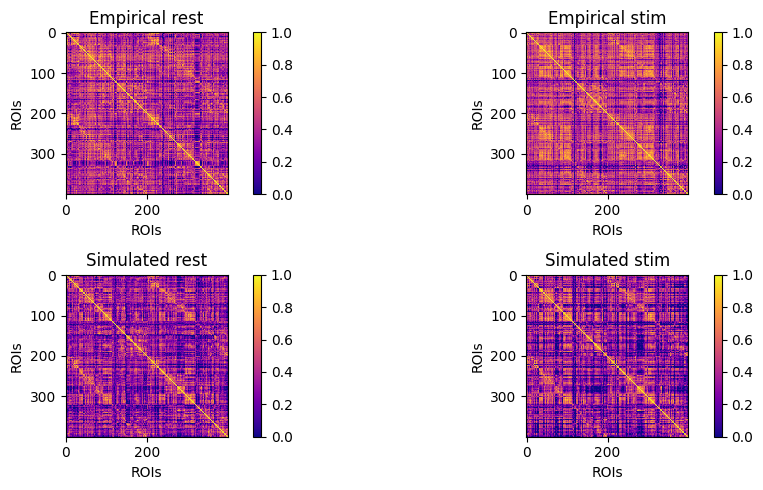

In [127]:
import matplotlib.pyplot as plt
vmin=0
vmax=1
plt.figure(figsize=(10,5))
plt.subplot(2,2,1)
plt.title('Empirical rest')
plt.imshow(np.corrcoef(emp_rest.T)[-n:,-n:],vmin=vmin,vmax=vmax,cmap='plasma',interpolation='nearest')
plt.colorbar()
plt.xlabel('ROIs')
plt.ylabel('ROIs')

plt.subplot(2,2,2)
plt.title('Empirical stim')
plt.imshow(np.corrcoef(emp_stim.T)[-n:,-n:],vmin=vmin,vmax=vmax,cmap='plasma',interpolation='nearest')
plt.colorbar()
plt.xlabel('ROIs')
plt.ylabel('ROIs')

plt.subplot(2,2,3)
plt.title('Simulated rest')
plt.imshow(np.corrcoef(sim_rest.T)[-n:,-n:],vmin=vmin,vmax=vmax,cmap='plasma',interpolation='nearest')
plt.colorbar()
plt.xlabel('ROIs')
plt.ylabel('ROIs')

plt.subplot(2,2,4)
plt.title('Simulated stim')
plt.imshow(np.corrcoef(sim_stim.T)[-n:,-n:],vmin=vmin,vmax=vmax,cmap='plasma',interpolation='nearest')
plt.colorbar()
plt.xlabel('ROIs')
plt.ylabel('ROIs')

#plt.axis('off')
plt.tight_layout()
plt.show()

In [128]:
n=400
tria=np.triu_indices(n,1)
vec_FC_emp_rest=FC_emp_rest[-n:,-n:][tria]
vec_FC_sim_rest=FC_sim_rest[-n:,-n:][tria]
vec_FC_emp_stim=FC_emp_stim[-n:,-n:][tria]
vec_FC_sim_stim=FC_sim_stim[-n:,-n:][tria]


r_emp_rest_VS_sim_rest=np.corrcoef(vec_FC_emp_rest,vec_FC_sim_rest)[0,1]
print('r_emp_rest_VS_sim_rest=%.3f'%r_emp_rest_VS_sim_rest)

r_emp_stim_VS_sim_stim=np.corrcoef(vec_FC_emp_stim,vec_FC_sim_stim)[0,1]
print('r_emp_stim_VS_sim_stim=%.3f'%r_emp_stim_VS_sim_stim)

r_emp_rest_VS_emp_stim=np.corrcoef(vec_FC_emp_rest,vec_FC_emp_stim)[0,1]
print('r_emp_rest_VS_emp_stim=%.3f'%r_emp_rest_VS_emp_stim)

r_sim_rest_VS_sim_stim=np.corrcoef(vec_FC_sim_rest,vec_FC_sim_stim)[0,1]
print('r_sim_rest_VS_sim_stim=%.3f'%r_sim_rest_VS_sim_stim)

r_emp_rest_VS_sim_stim=np.corrcoef(vec_FC_emp_rest,vec_FC_sim_stim)[0,1]
print('r_emp_rest_VS_sim_stim=%.3f'%r_emp_rest_VS_sim_stim)

r_sim_rest_VS_emp_stim=np.corrcoef(vec_FC_sim_rest,vec_FC_emp_stim)[0,1]
print('r_sim_rest_VS_emp_stim=%.3f'%r_sim_rest_VS_emp_stim)


r_emp_rest_VS_sim_rest=0.437
r_emp_stim_VS_sim_stim=0.437
r_emp_rest_VS_emp_stim=0.536
r_sim_rest_VS_sim_stim=0.715
r_emp_rest_VS_sim_stim=0.400
r_sim_rest_VS_emp_stim=0.434


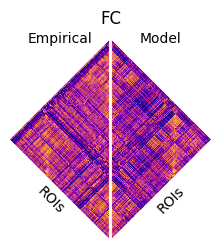

In [97]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.transforms import Affine2D
from matplotlib.patches import Polygon

# FC_emp and FC_sim are square (n x n) numpy arrays
# Example color limits (change if you like)
vmin, vmax = 0, 1

# We'll place the (0..1, 0..1) image into a square [-1,1]x[-1,1] then rotate 45°
extent = (-1, 1, -1, 1)

fig, ax = plt.subplots(figsize=(2.6,2.6))
ax.set_aspect('equal')
ax.set_axis_off()

# 45° rotation for anything that should align with the matrix axes (images + grid)
rot = Affine2D().rotate_deg(45) + ax.transData

# --- draw left (Empirical) half ---
im_emp = ax.imshow(FC_emp_rest, origin='lower', extent=extent,
                   vmin=vmin, vmax=vmax, cmap='plasma', transform=rot,interpolation='nearest')
# clip to left triangle (x <= 0 in unrotated data coords)

# Y label (left, vertical)
clip_left = Polygon([(-1, 0), (0, 1), (0, -1)], closed=True,
                    facecolor='none', edgecolor='none', transform=ax.transData)
im_emp.set_clip_path(clip_left)

# --- draw right (Model) half ---
im_sim = ax.imshow(FC_sim_rest, origin='lower', extent=extent,
                   vmin=vmin, vmax=vmax, cmap='plasma', transform=rot,interpolation='nearest')

# Y label (left, vertical)
# clip to right triangle (x >= 0)
clip_right = Polygon([(0, -1), (0, 1), (1, 0)], closed=True,
                     facecolor='none', edgecolor='none', transform=ax.transData)
im_sim.set_clip_path(clip_right)

# central separator
ax.plot([0, 0], [-1, 1], color='w', lw=2)

# labels
ax.text(0., 1.2, 'FC', color='k', ha='center', va='center',
        fontsize=12)

ax.text(-0.5, 1.0, 'Empirical', color='k', ha='center', va='center',
        fontsize=10)
ax.text(0.5, 1.0, 'Model', color='k', ha='center', va='center',
        fontsize=10)

# Y-axis label (left center, rotated)
ax.text(-.6, -0.6, 'ROIs', ha='center', va='center',
        fontsize=10, rotation=-45)

# Y-axis label (left center, rotated)
ax.text(0.6, -0.6, 'ROIs', ha='center', va='center',
        fontsize=10, rotation=45)

plt.tight_layout()
#plt.savefig('FC_emp_vs_sim.png',dpi=300, transparent=True)
plt.show()

In [44]:
np.corrcoef(FC_emp[np.triu_indices(450,1)],FC_sim[np.triu_indices(450,1)])

array([[1.        , 0.19445731],
       [0.19445731, 1.        ]])

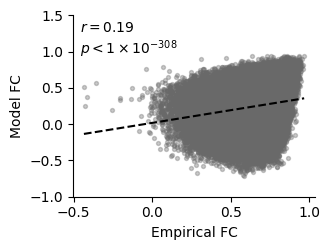

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, linregress

# --- take upper triangle (excluding diagonal) ---
tri = np.triu_indices_from(FC_emp, k=1)
x = FC_emp[tri].astype(float).ravel()
y = FC_sim[tri].astype(float).ravel()

# remove NaNs / infs if any
m = np.isfinite(x) & np.isfinite(y)
x, y = x[m], y[m]

# stats
r, p = pearsonr(x, y)
lr = linregress(x, y)  # slope, intercept, rvalue, pvalue, stderr, intercept_stderr

# --- plot ---
fig, ax = plt.subplots(figsize=(3.4, 2.6))
ax.scatter(x, y, s=8, alpha=0.35,c='dimgray')

# regression line
xx = np.linspace(x.min(), x.max(), 200)
ax.plot(xx, lr.slope * xx + lr.intercept, linewidth=1.5,c='k',linestyle='--')

# identity line for reference
#lo, hi = min(x.min(), y.min()), max(x.max(), y.max())
#ax.plot([lo, hi], [lo, hi], linestyle='--', linewidth=1)

ax.set_xlabel('Empirical FC')
ax.set_ylabel('Model FC')
#ax.set_title('Empirical vs. Model FC')

# format p-value as mantissa × 10^{exponent}
if p == 0:
    p_str = r"$p < 1\times 10^{-308}$"   # avoids log10(0)
else:
    exponent = int(np.floor(np.log10(p)))
    mantissa = p / 10**exponent
    p_str = rf"$p = {mantissa:.2f}\times 10^{{{exponent}}}$"

# annotate correlation + p-value
ax.text(0.03, 0.97, rf"$r = {r:.2f}$" + "\n" + p_str,
        transform=ax.transAxes, ha="left", va="top")

# turn off top and right axes spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ticks = ax.get_xticks()
ax.set_yticks(ticks)

plt.tight_layout()
#plt.savefig('FC_emp_vs_sim_scatter.png',dpi=300, transparent=True)
plt.show()

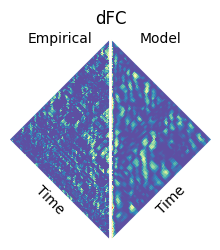

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.transforms import Affine2D
from matplotlib.patches import Polygon

# dFC_emp and dFC_sim are square (n x n) numpy arrays
# Example color limits (change if you like)
vmin, vmax = -0, 1.

# We'll place the (0..1, 0..1) image into a square [-1,1]x[-1,1] then rotate 45°
extent = (-1, 1, -1, 1)

fig, ax = plt.subplots(figsize=(2.6,2.6))
ax.set_aspect('equal')
ax.set_axis_off()

# 45° rotation for anything that should align with the matrix axes (images + grid)
rot = Affine2D().rotate_deg(45) + ax.transData

# --- draw left (Empirical) half ---
im_emp = ax.imshow(dFC_emp, origin='lower', extent=extent,
                   vmin=vmin, vmax=vmax, cmap='Spectral_r', transform=rot,interpolation='nearest')
# clip to left triangle (x <= 0 in unrotated data coords)

# Y label (left, vertical)
clip_left = Polygon([(-1, 0), (0, 1), (0, -1)], closed=True,
                    facecolor='none', edgecolor='none', transform=ax.transData)
im_emp.set_clip_path(clip_left)

# --- draw right (Model) half ---
im_sim = ax.imshow(dFC_sim, origin='lower', extent=extent,
                   vmin=vmin, vmax=vmax, cmap='Spectral_r', transform=rot,interpolation='nearest')

# Y label (left, vertical)
# clip to right triangle (x >= 0)
clip_right = Polygon([(0, -1), (0, 1), (1, 0)], closed=True,
                     facecolor='none', edgecolor='none', transform=ax.transData)
im_sim.set_clip_path(clip_right)

# central separator
ax.plot([0, 0], [-1, 1], color='w', lw=2)

# labels
ax.text(0., 1.2, 'dFC', color='k', ha='center', va='center',
        fontsize=12)

ax.text(-0.5, 1.0, 'Empirical', color='k', ha='center', va='center',
        fontsize=10)
ax.text(0.5, 1.0, 'Model', color='k', ha='center', va='center',
        fontsize=10)

# Y-axis label (left center, rotated)
ax.text(-.6, -0.6, 'Time', ha='center', va='center',
        fontsize=10, rotation=-45)

# Y-axis label (left center, rotated)
ax.text(0.6, -0.6, 'Time', ha='center', va='center',
        fontsize=10, rotation=45)

plt.tight_layout()
#plt.savefig('dFC_emp_vs_sim.png',dpi=300, transparent=True)
plt.show()

In [160]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp

# --- take upper triangle (excluding diagonal) ---
tri = np.triu_indices_from(dFC_emp, k=1)
x = dFC_emp[tri].astype(float).ravel()
y = dFC_sim[tri].astype(float).ravel()

# remove NaNs / infs if any
m = np.isfinite(x) & np.isfinite(y)
x, y = x[m], y[m]

# --- KS test ---
D, p = ks_2samp(x, y)

# format p-value as mantissa × 10^{exponent}
if p == 0:
    p_str = r"$p < 1\times 10^{-308}$"
else:
    exponent = int(np.floor(np.log10(p)))
    mantissa = p / 10**exponent
    p_str = rf"$p = {mantissa:.2f}\times 10^{{{exponent}}}$"

# --- plot ---
fig, ax = plt.subplots(figsize=(3.4, 2.6))

# histograms
bins = 40
ax.hist(x, bins=bins, alpha=0.6, label="Empirical", density=True)
ax.hist(y, bins=bins, alpha=0.6, label="Model", density=True, color='dimgray')

ax.set_xlabel('dFC values')
ax.set_ylabel('Density')

# annotate KS test results
#ax.text(0.03, 0.97, rf"$D = {D:.2f}$" + "\n" + p_str,
#        transform=ax.transAxes, ha="left", va="top")

# tidy up axes
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# legend (move outside the plot to avoid overlap)
# Put legend at upper right, labels below the boxes
# shrink current axis by 20% (leave room on the right)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# now put legend to the right
ax.legend(frameon=False, loc='upper right')
plt.tight_layout()
#plt.savefig('dFC_emp_vs_sim_hist.png', dpi=300, transparent=True)
plt.show()

IndexError: index 201 is out of bounds for axis 0 with size 201

# All Subjects (I only removed subject 6 because it does not fit well!)

In [ ]:
# Empirical static and dynamic FC for all subjects
FCs_emp={}
dFCs_emp={}
FCs_sim={}
dFCs_sim={}
for isu in range(len(subject_ids)):
  sig_path = os.path.join(preproc_dir, f"{subject_ids[isu]}_signals.npy")
  inp_path = os.path.join(preproc_dir, f"{subject_ids[isu]}_inputs.npy")
  tgt_path = os.path.join(preproc_dir, f"{subject_ids[isu]}_targets.npy")
  mdl_path = os.path.join(weights_dir,  f"population_MLP_tms_fmri.pt")

  Z = np.load(sig_path)
  X = np.load(inp_path)             # (M, S*N)
  Y = np.load(tgt_path)             # (M, N)

  # Load model
  model = load_model(mdl_path, X, Y)

  S=3 #number of steps
  N=Z.shape[1] #number of regions
  Zsim = NPI.model_time_series(model, np.zeros((S,N)), tlen=240, noise_strength=.3)

  test_dur=180 #int(len(Z)-len(Z)/100*80)

  emp=Z[-test_dur:,:]
  sim=Zsim[-test_dur:,:]

  FCs_emp[isu]=np.corrcoef(emp.T)
  FCs_sim[isu]=np.corrcoef(sim.T)

  dFCs_emp[isu]=dFC(emp)
  dFCs_sim[isu]=dFC(sim)

In [ ]:
T=emp.shape[0]   # time points
N=emp.shape[1]   # number of regions
tri_N=np.triu_indices(N,1)
tri_T=np.triu_indices(T,1)

In [ ]:
Corr_FC_emp_VS_sim={}
Fluidity_emp={}
Fluidity_sim={}
for isu in range(len(subject_ids)):
  Corr_FC_emp_VS_sim[isu]=stats.pearsonr(FCs_emp[isu][tri_N],FCs_sim[isu][tri_N])[0]
  Fluidity_emp[isu]=np.var(dFCs_emp[isu][tri_T])
  Fluidity_sim[isu]=np.var(dFCs_sim[isu][tri_T])

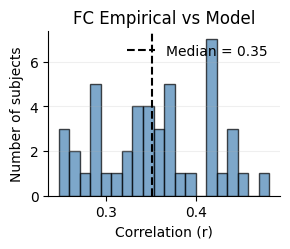

In [ ]:
data = np.asarray(list(Corr_FC_emp_VS_sim.values()))

# --- Plot histogram ---
fig, ax = plt.subplots(figsize=(3, 2.6))

ax.hist(data, bins=20, color='steelblue', edgecolor='black', alpha=0.7)
ax.axvline(np.median(data), color='k', linestyle='--', lw=1.5, label=f"Median = {np.median(data):.2f}")

# Cosmetic tweaks
ax.set_title('FC Empirical vs Model')
ax.set_xlabel("Correlation (r)")
ax.set_ylabel("Number of subjects")
#ax.set_xlim(0.7, 1.0)
ax.legend(frameon=False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='y', alpha=0.2)

plt.tight_layout()
plt.show()

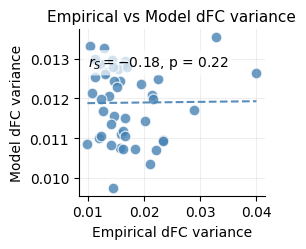

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress, pearsonr

# --- align subjects present in both ---
idx = sorted(set(Fluidity_emp.keys()) & set(Fluidity_sim.keys()))
x = np.array([Fluidity_emp[i] for i in idx], float)  # empirical
y = np.array([Fluidity_sim[i] for i in idx], float)  # model

# --- Scatter plot ---
fig, ax = plt.subplots(figsize=(2.9, 2.6))

sc = ax.scatter(x, y, s=60, color='steelblue',
                edgecolor='white', linewidth=0.9, alpha=0.8)

# --- Regression line ---
lr = linregress(x, y)
xx = np.linspace(x.min(), x.max(), 200)
ax.plot(xx, lr.slope*xx + lr.intercept, color='steelblue',
        linewidth=1.5, linestyle="--", alpha=0.9)

# --- Identity line (y=x) ---
#lo, hi = min(x.min(), y.min()), max(x.max(), y.max())
#ax.plot([lo, hi], [lo, hi], ls="--", lw=1, color="k", alpha=0.4)
#ax.set_xlim(lo, hi)
#ax.set_ylim(lo, hi)

# --- Correlation ---
r, p = stats.spearmanr(x, y)
ax.text(0.05, 0.85, f"$r_S = {r:.2f}$, p = {p:.2g}",
        transform=ax.transAxes, va='top', ha='left', fontsize=10,
        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="none", alpha=0.7))

# --- Labels & style ---
ax.set_xlabel("Empirical dFC variance")
ax.set_ylabel("Model dFC variance")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(alpha=0.2)
ax.set_title("Empirical vs Model dFC variance", fontsize=11)

plt.tight_layout()
plt.show()


In [ ]:
#EC_t = NPI.model_ECt(model, input_X=X[:400,:], target_Y=Y[:400,:], pert_strength=0.1)

In [ ]:
#EC_t.shape

(400, 450, 450)